<a href="https://colab.research.google.com/github/Kasper-Raupach-Haurum/M6-Data-Engineering-and-MLOps/blob/main/M6_Data_Engineering_and_MLOps_Assignment_2_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Select one of your previous projects or a large dataset of your choice, such as a dataset with millions of rows, and use either Apache Spark or Polars to perform the complete EDA report.

This colab and code was made by Raiyan M.D, and Kasper R. Haurum on the Business data science master at their 2nd semester, for Module 6: Data Engineering and MLOps.

In this assignment 2, we will use the "Nomadlist" dataset, which is a dataset used in our 1st semester within the M1 - Applied Data Science and Machine Learning module.

Lastly, we will use Apache Spark to perform the EDA & data operations.

##Loading the dataset and basic EDA

Here we are loading the dataset and performing basic exploratory data analysis (EDA) using PySpark. The purpose of this analysis is to understand the structure of the data, filter relevant observations, and obtain summary statistics or metrics.

In [1]:
!pip install pyspark --q

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, min, max, mean
import pandas as pd
import pyspark.sql.functions as F

`spark = SparkSession.builder.appName("TripsEDA").getOrCreate()` is a line of code in PySpark that creates a Spark session.

A Spark session is the entry point to using Spark functionality. It serves as a unified entry point for accessing Spark services and provides a way to manage the SparkContext, which is the main object that controls the behavior of Spark.

In this line of code, a Spark session is created using the `SparkSession.builder` method and setting the appName to `"TripsEDA"`. The `getOrCreate` method is used to either get an existing Spark session or create a new one if none exists. This ensures that only one Spark session is created for the entire analysis.

In [3]:
spark = SparkSession.builder.appName("TripsEDA").getOrCreate()

In this part of the code we are using the ` urllib.request — Extensible library` for opening URLs. This is required because we want to download down the trips.csv dataset from a github repo. It downloads the dataset from the specified URL using the urllib.request module.

The URL of the dataset is stored in a variable url and the name of the file is stored in a variable filename. We also implemented a print() for both prior, and after using the request function of the urllib, as we want to make sure we get a confirmation that it worked.

In [4]:
#Download the dataset
import urllib.request

url = 'https://sds-aau.github.io/SDS-master/M1/data/trips.csv'
filename = 'trips.csv'

print('Downloading the dataset')
urllib.request.urlretrieve(url, filename)
print('Dataset downloaded successfully')

Dataset downloaded successfully.


This part of the code loads the dataset into a Spark dataframe and performs basic exploratory data analysis (EDA) to understand the structure of the data.

The following line of code loads the dataset into a Spark dataframe:

`df = spark.read.format('csv').options(header='true', inferSchema='true').load(filename)`

The load method is used to load the data from the specified file (filename) into a Spark dataframe (df).

Finally, the message "Dataset loaded successfully" is printed to again act as a canary bird to inform us that the spark command worked.

In [5]:
#Step 1: Load the dataset into the platform and perform basic exploratory data analysis (EDA) to understand the structure of the data. 
#Load the dataset into a Spark dataframe
print('Loading the dataset into a Spark dataframe')
df = spark.read.format('csv').options(header='true', inferSchema='true').load(filename)
print('Dataset loaded successfully')

Loading the dataset into a Spark dataframe...
Dataset loaded successfully.


Here we have written a combined function which prints the dimensions of the Trips dataset, which is 46510 rows, and 11 columns. Accompanying this print() comes the data types of the different columns, and lastly, the missing values found in the dataset. As seen, this is as high as 601 missing values found in `country_code`, and some without any missing values.

In [6]:
# Perform basic exploratory data analysis
print("Dimensions of the dataset: ({}, {})".format(df.count(), len(df.columns)))
print("Data types:")
df.printSchema()
print("Missing values:")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(truncate=False)

Dimensions of the dataset: (46510, 11)
Data types:
root
 |-- _c0: integer (nullable = true)
 |-- username: string (nullable = true)
 |-- country: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- country_slug: string (nullable = true)
 |-- date_end: string (nullable = true)
 |-- date_start: string (nullable = true)
 |-- latitude: integer (nullable = true)
 |-- longitude: integer (nullable = true)
 |-- place: string (nullable = true)
 |-- place_slug: string (nullable = true)

Missing values:
+---+--------+-------+------------+------------+--------+----------+--------+---------+-----+----------+
|_c0|username|country|country_code|country_slug|date_end|date_start|latitude|longitude|place|place_slug|
+---+--------+-------+------------+------------+--------+----------+--------+---------+-----+----------+
|0  |0       |37     |601         |37          |175     |0         |0       |0        |2    |37        |
+---+--------+-------+------------+------------+--------+---

Since we detected there was missing values, we want to ensure of course that these missing values are removed. To ensure this, we do the following to filter the data to include only the relevant observations.

`df = df.filter((col("date_end") > col("date_start")) & (col("latitude").isNotNull()) & (col("longitude").isNotNull())) `

This code filters the data based on three conditions:
 
1.   col("date_end") > col("date_start"): The end date of the trip must be greater than the start date. In other words, the end_date is always greater as when days passes by, the value increases. 1/1/2023 is smaller then 7/1/2023. This is to ensure the trips are not negative in duration, and we wanted to make a duration-filter, so this is it.

2.   col("latitude").isNotNull(): The latitude of the trip must not be null. 

3.   col("longitude").isNotNull(): The longitude of the trip must not be null.
The filtered data is stored in the same dataframe df.

2 + 3 is to ensure that the trips have a location data point

In [7]:
# Step 2: Filter the data to include only the relevant observations
print("Filtering the data to include only the relevant observations...")
df = df.filter((col("date_end") > col("date_start")) & (col("latitude").isNotNull()) & (col("longitude").isNotNull()))

Filtering the data to include only the relevant observations...


Now that we have set the conditions for which the data in the trips data is filtered, we want to group.by some of the variables in the dataset. What we want to look at in this example is where most digital nomads travel to, be it either country, or place, and which digital nomad is the most frequent flier.

To find this information, we do the following:

* `df.groupBy("country").agg(count("*").alias("count")):` The data is grouped by the country and the number of trips per country is counted.

* `df.groupBy("place").agg(count("*").alias("count")):` The data is grouped by the place and the number of trips per place is counted.

* `df.groupBy("username").agg(count("*").alias("count")):` The data is grouped by the username and the number of trips per username is counted.

In [8]:
# Step 3: Aggregate the data to obtain summary statistics or metrics
print("Aggregating the data to obtain summary statistics or metrics...")
print("Number of trips per country:")
df.groupBy("country").agg(count("*").alias("count")).show(truncate=False)
print("Number of trips per place:")
df.groupBy("place").agg(count("*").alias("count")).show(truncate=False)
print("Number of trips per username:")
df.groupBy("username").agg(count("*").alias("count")).show(truncate=False)

Aggregating the data to obtain summary statistics or metrics...
Number of trips per country:
+----------------------------+-----+
|country                     |count|
+----------------------------+-----+
|Côte d'Ivoire               |1    |
|Chad                        |1    |
|Russia                      |491  |
|Paraguay                    |15   |
|Anguilla                    |2    |
|Bethlehem                   |1    |
|U.S. Virgin Islands         |6    |
|Yemen                       |1    |
|Pristina District           |1    |
|Senegal                     |11   |
|Collectivity of Saint Martin|3    |
|Sweden                      |361  |
|Mediterranean Sea           |3    |
|Svalbard and Jan Mayen      |6    |
|Philippines                 |376  |
|11000                       |1    |
|Iguazu Falls                |1    |
|Tonga                       |2    |
|Djibouti                    |1    |
|Malaysia                    |872  |
+----------------------------+-----+
only showing top 20

As you saw above, the output is a mess as far as what is high, and what is low, and we don't want messy data, we want clean data. So, to make clean data we want to find the min, max, and mean values for the groupby.data. To begin, we find the min, max, and mean value for the country and the number of trips per country. As seen, the most popular country recieved 7337 digital nomads, and countries on average gets 181 visitors, and the lowest of the low gets just 1 nomad, likely one who felt very lonely sitting in some sweaty hotel lobby, and sipping on a bottle of Stella artois

In [9]:
# Calculating summary statistics for trips per country
country_stats = df.groupBy("country").agg(count("*").alias("count"))
country_stats.select(min("count").alias("Min"), max("count").alias("Max"), mean("count").alias("Mean")).show()

+---+----+-----------------+
|Min| Max|             Mean|
+---+----+-----------------+
|  1|7337|181.1093117408907|
+---+----+-----------------+



We do the same for place locations

In [10]:
# Calculating summary statistics for trips per place
place_stats = df.groupBy("place").agg(count("*").alias("count"))
place_stats.select(min("count").alias("Min"), max("count").alias("Max"), mean("count").alias("Mean")).show()

+---+----+-----------------+
|Min| Max|             Mean|
+---+----+-----------------+
|  1|1247|9.896902654867256|
+---+----+-----------------+



And the same for users on the nomadlist

In [11]:
# Calculating summary statistics for trips per username
username_stats = df.groupBy("username").agg(count("*").alias("count"))
username_stats.select(min("count").alias("Min"), max("count").alias("Max"), mean("count").alias("Mean")).show()

+---+---+------------------+
|Min|Max|              Mean|
+---+---+------------------+
|  1|835|15.630328441649196|
+---+---+------------------+



The code block` "# Show the top 10 countries, places, and usernames"` displays the top 10 countries, places, and usernames with the most number of trips. The code orders the data based on the number of trips in descending order and then shows the top 10 entries. The truncate=False option is used to display all the data without truncating it.

In [12]:
# Show the top 10 countries, places, and usernames
print("Top 10 countries:")
country_stats.orderBy(F.desc("count")).show(10, truncate=False)
print("Top 10 places:")
place_stats.orderBy(F.desc("count")).show(10, truncate=False)
print("Top 10 usernames:")
username_stats.orderBy(F.desc("count")).show(10, truncate=False)

Top 10 countries:
+--------------+-----+
|country       |count|
+--------------+-----+
|United States |7337 |
|Thailand      |3305 |
|United Kingdom|2135 |
|Spain         |1927 |
|Germany       |1907 |
|France        |1448 |
|Indonesia     |1322 |
|China         |1091 |
|Italy         |1061 |
|Netherlands   |1046 |
+--------------+-----+
only showing top 10 rows

Top 10 places:
+-------------+-----+
|place        |count|
+-------------+-----+
|Bangkok      |1247 |
|London       |1224 |
|Chiang Mai   |905  |
|New York City|902  |
|Berlin       |851  |
|San Francisco|808  |
|Paris        |707  |
|Amsterdam    |703  |
|Barcelona    |644  |
|Kuala Lumpur |544  |
+-------------+-----+
only showing top 10 rows

Top 10 usernames:
+------------+-----+
|username    |count|
+------------+-----+
|@scottbrills|835  |
|@adamnowek  |548  |
|@replay     |297  |
|@raoul      |233  |
|@tkrunning  |233  |
|@levelsio   |215  |
|@mv         |200  |
|@iamfledge  |187  |
|@jackveiga  |186  |
|@kumi       |1

And here, we instead display the bottom 10 countries, places, and usernames with the least number of trips. It arranges the data based on the number of trips in increasing order and then shows the top 10 entries. The truncate=False option means that all the data will be displayed without being cut off.

In [13]:
# Show the bottom 10 countries, places, and usernames
print("Bottom 10 countries:")
country_stats.orderBy(F.asc("count")).show(10, truncate=False)
print("Bottom 10 places:")
place_stats.orderBy(F.asc("count")).show(10, truncate=False)
print("Bottom 10 usernames:")
username_stats.orderBy(F.asc("count")).show(10, truncate=False)

Bottom 10 countries:
+-----------------+-----+
|country          |count|
+-----------------+-----+
|Prishtina        |1    |
|Lower Subansiri  |1    |
|Europe           |1    |
|Chad             |1    |
|Palau            |1    |
|Bethlehem        |1    |
|Finnland         |1    |
|Pristina District|1    |
|Abkhazia         |1    |
|11000            |1    |
+-----------------+-----+
only showing top 10 rows

Bottom 10 places:
+----------------------------------+-----+
|place                             |count|
+----------------------------------+-----+
|Hargeisa                          |1    |
|Sant Llorenç de Morunys           |1    |
|Hanover                           |1    |
|Magdeburg                         |1    |
|Seogwipo-si                       |1    |
|Nukus                             |1    |
|Carbost                           |1    |
|Canyon de Chelly National Monument|1    |
|Songpan                           |1    |
|Banlung                           |1    |
+-----------

In [121]:
# Step 5: Visualize the data
# Import the necessary libraries
import matplotlib.pyplot as plt

In [122]:
# Set the figure size
plt.figure(figsize=(15,5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [123]:
# Group the data by place and count the number of trips in each group
trips_by_place = df.groupBy("place").agg(count("*").alias("count"))

In [124]:
# Select the top 10 most visited places
top_places = trips_by_place.orderBy(F.desc("count")).limit(10)

Text(0, 0.5, 'Number of Trips')

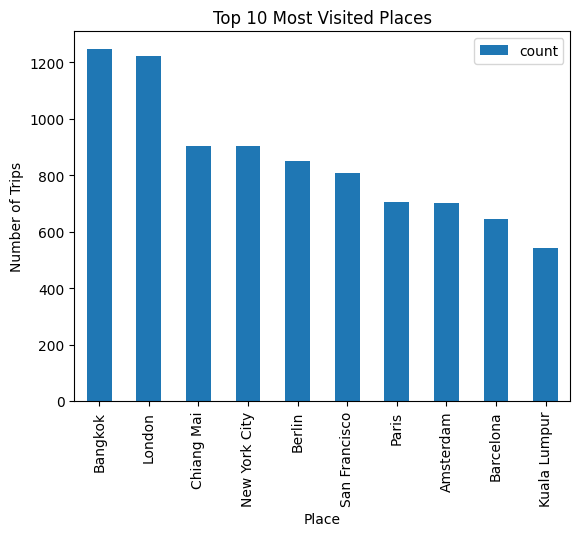

In [125]:
# Convert the data to a Pandas dataframe and plot a bar chart
top_places.toPandas().plot(kind="bar", x="place", y="count")
plt.title("Top 10 Most Visited Places")
plt.xlabel("Place")
plt.ylabel("Number of Trips")

In [126]:
# Set the figure size
plt.figure(figsize=(15,5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [127]:
# Group the data by username and count the number of trips in each group
trips_by_username = df.groupBy("username").agg(count("*").alias("count"))

In [128]:
# Select the top 10 most visited usernames
top_usernames = trips_by_username.orderBy(F.desc("count")).limit(10)

Text(0, 0.5, 'Number of Trips')

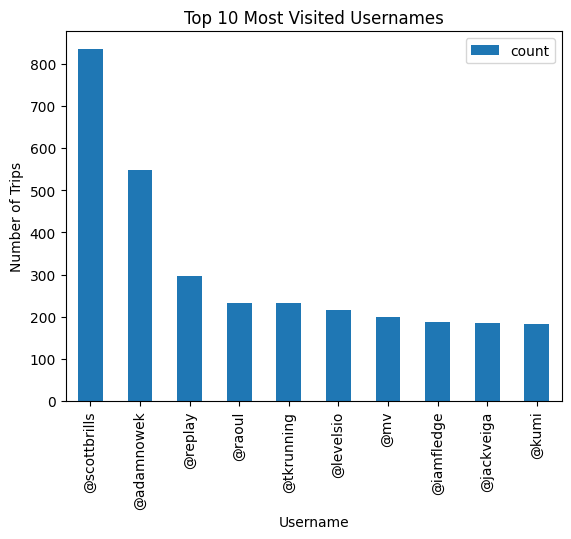

In [129]:
# Convert the data to a Pandas dataframe and plot a bar chart
top_usernames.toPandas().plot(kind="bar", x="username", y="count")
plt.title("Top 10 Most Visited Usernames")
plt.xlabel("Username")
plt.ylabel("Number of Trips")

In [130]:
# Set the figure size
plt.figure(figsize=(15,5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [131]:
# Group the data by country and count the number of trips in each group
trips_by_country = df.groupBy("country").agg(count("*").alias("count"))

In [132]:
# Select the top 10 most visited countries
top_countries = trips_by_country.orderBy(F.desc("count")).limit(10)

Text(0, 0.5, 'Number of Trips')

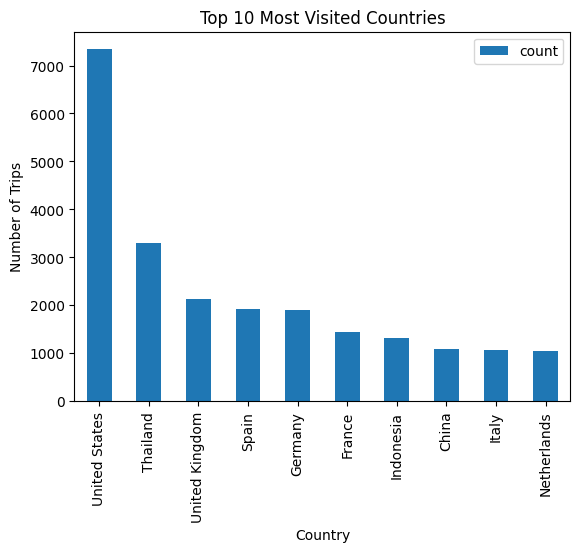

In [133]:
# Convert the data to a Pandas dataframe and plot a bar chart
top_countries.toPandas().plot(kind="bar", x="country", y="count")
plt.title("Top 10 Most Visited Countries")
plt.xlabel("Country")
plt.ylabel("Number of Trips")